In [ ]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
CREDIT_PATH = "credit_default.csv"
credit_df  = pd.read_csv(CREDIT_PATH)

# Separate predictors and response
X = credit_df.drop(columns=['default'])
y = credit_df['default'] #target


print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

feature_names = X.columns

# Train‑test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Feature scaling
scaler_cd = StandardScaler()
X_train_scaled = scaler_cd.fit_transform(X_train)
X_test_scaled  = scaler_cd.transform(X_test)

Shape of X: (200, 50)
Shape of y: (200,)


1. Fit a standard logistic regression. Estimate test accuracy via 10–fold cross–validation. Com-
pare the estimated test accuracy with the actual test accuracy

In [ ]:
#fit a standard logistic regression

#add the const only for the UNpenalized logreg
#X_train1_scaled = sm.add_constant(X_train_scaled)
#X_test1_scaled = sm.add_constant(X_test_scaled)

#using very large C to have a base log reg
log_reg = LogisticRegression(penalty='l2',C = 1e8,solver = 'liblinear',max_iter =1000)#no penalty (alpha = 1/C == 0), standard LogREG (includes the intercept for the predictions)
log_reg.fit(X_train_scaled, y_train)

from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score

#estimate the test accuracy via cross validation
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42) #Logistic Reg better to use stratified

#
#k=10
#create the metrics for scoring
scoring = {'Accuracy': make_scorer(accuracy_score)}
results = {}

#ACCURACY VIA CROSS VALIDATION
#fit the model
for metric,scorer in scoring.items():
  #compute the cross validation score passing the regressor, data train scaled and as cv the kfold we created
  scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=kf, scoring=scorer)
  results[metric] = (np.mean(scores), np.std(scores))
  print(f"estimate test {metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

#scores = cross_val_score(log_reg, X_train_scaled, y_train,scoring='accuracy', cv=kf)
#cv_acc = scores.mean()

#convert prob to predictions
y_pred = log_reg.predict(X_test_scaled) #already labels

#TEST ACCURACY ON THE real TEST SET
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, log_reg.predict(X_test_scaled))

#print(f"Standard logistic – CV accuracy:  {cv_acc:.3f}")
print(f"Standard logistic – Test accuracy: {test_acc:.3f}")

estimate test Accuracy: 0.7214 ± 0.1172
Standard logistic – Test accuracy: 0.650


Repeat with ridge and lasso penalties. Use 10-fold cross-validation to estimate the parameters. Report the best C values and compare test accuracies.

In [ ]:
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
#using 10 fold cv to find the optimal parameters for log_reg penalized
ridge_log_reg = LogisticRegression(penalty='l2', solver='liblinear',max_iter=1000)
lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear',max_iter=1000)

#We use CV based on the accuracy to come up with the best alpha ( metric = accuracy )

#Nei modelli di regressione logistica di scikit-learn, si usa C come inverso della forza di regolarizzazione.
# C = 1/alpha
# Logistic Regression (L2)
logreg_l2_params = {'C': np.logspace(-3, 3,15)}
#CV USING 10 FOLDS
logreg_l2_cv = GridSearchCV(ridge_log_reg, logreg_l2_params, cv=10, scoring='accuracy') #automatically implements Stratified Kfold


#Nei modelli di regressione logistica di scikit-learn, si usa C come inverso della forza di regolarizzazione.
# C = 1/alpha

# Logistic Regression (L1)
logreg_l1_params = {'C': np.logspace(-3, 3, 15)}
#CV USING 10 FOLDS
logreg_l1_cv = GridSearchCV(lasso_log_reg, logreg_l1_params, cv=10 ,scoring='accuracy')
# Fit models
logreg_l2_cv.fit(X_train_scaled, y_train)
logreg_l1_cv.fit(X_train_scaled, y_train)

print("Best C for Logistic Regression (L2) RIDGE :", logreg_l2_cv.best_params_['C'])
print("Best C for Logistic Regression (L1) LASSO:", logreg_l1_cv.best_params_['C'])

optimal_C_ridge = logreg_l2_cv.best_params_['C']
optimal_C_lasso = logreg_l1_cv.best_params_['C']

alpha_optimal_ridge = 1/optimal_C_ridge
alpha_optimal_lasso = 1/optimal_C_lasso

print("Optimal alpha for Ridge:", alpha_optimal_ridge)
print("Optimal alpha for Lasso:", alpha_optimal_lasso)

#C = 1/alpha

optimal_ridge_log_reg = LogisticRegression(penalty='l2', solver='liblinear', C=optimal_C_ridge, max_iter=1000)
optimal_lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=optimal_C_lasso, max_iter=1000)

#using the optimal C we can calculate the test error using cross-validation and the real test set

#real test accuracy
optimal_ridge_log_reg.fit(X_train_scaled, y_train)
optimal_lasso_log_reg.fit(X_train_scaled, y_train)
pred = optimal_ridge_log_reg.predict(X_test_scaled)
print(f"Real Test accuracy for RIDGE using optimal alpha: {accuracy_score(y_test, pred)}")
pred = optimal_lasso_log_reg.predict(X_test_scaled)
print(f"Real Test accuracy for LASSO using optimal alpha: {accuracy_score(y_test, pred)}")

#test accuracy via k-cross validation
kf = KFold(n_splits=K, shuffle=True, random_state=123)
scores_ridge = cross_val_score(optimal_ridge_log_reg, X_train_scaled, y_train,scoring='accuracy', cv=kf)
print(f"Estimated Test accuracy via cross validation for RIDGE: {scores_ridge.mean()}")
scores_lasso = cross_val_score(optimal_lasso_log_reg, X_train_scaled, y_train,scoring='accuracy', cv=kf)
print(f"Estimated Test accuracy via cross validation for LASSO: {scores_lasso.mean()}")

Best C for Logistic Regression (L2) RIDGE : 0.004281332398719396
Best C for Logistic Regression (L1) LASSO: 0.13894954943731375
Optimal alpha for Ridge: 233.57214690901213
Optimal alpha for Lasso: 7.196856730011521
Real Test accuracy for RIDGE using optimal alpha: 0.7
Real Test accuracy for LASSO using optimal alpha: 0.8
Estimated Test accuracy via cross validation for RIDGE: 0.8142857142857143
Estimated Test accuracy via cross validation for LASSO: 0.8214285714285714


3. Train a random forest (300 trees, oob score=True). Report OOB accuracy, test accuracy,
and plot the top–10 feature importances

In [ ]:
#Libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
#AVERAGING all the predictions from all the trees to reduce the variance of a new prediction / Num_trees

In [1]:
num_trees = 300
# Train Random Forest
rf = RandomForestClassifier(n_estimators=num_trees, random_state=42,oob_score=True) #Hyperparams: n_trees = n_estimators, depth, m (predictors)
rf.fit(X_train_scaled, y_train)

# Predict
y_pred = rf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"OOB Accuracy: {rf.oob_score_:.3f}")
#plot the first 10 importance features
#Questo perche ovviamente ho piu accuracy nella prediction ma perdo nell'interpretabilità del singolo albero
import matplotlib.pyplot as plt

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

#features_names da definire quando preparo dataset

#sorted_features = feature_names[sorted_idx]
sorted_features_rf = np.array(feature_names)[sorted_idx]
print("top 10 features ordered by importance discovered in RF: ", sorted_features_rf[:10])
sorted_importance_coeffs_randomforest = importances[sorted_idx]

# Seleziona tutte le feature se sono meno di 10, altrimenti solo le prime 10
n_features_to_plot = len(sorted_features_rf) if len(sorted_features_rf) < 10 else 10

plt.figure(figsize=(8, 6))
plt.barh(sorted_features_rf[:n_features_to_plot], sorted_importance_coeffs_randomforest[:n_features_to_plot])
plt.xlabel("Feature Importance")
plt.title("top 10 Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


NameError: name 'RandomForestClassifier' is not defined

4. Report the adjusted rand index between the top–10 features according to random forest and
the features selected by Lasso with the optimal C parameter.

In [ ]:
from sklearn.metrics import adjusted_rand_score
#Variable selection using Lasso
optimal_lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=optimal_C_lasso, max_iter=1000)
optimal_lasso_log_reg.fit(X_train_scaled, y_train)

# 1. Estrai TUTTI i coefficienti dal modello
all_lasso_coefs = optimal_lasso_log_reg.coef_[0]

# 2. Definisci la soglia di significatività
threshold = np.exp(-12)

# 3. Crea una "maschera" booleana: True per i coefficienti il cui valore assoluto è sopra la soglia
significant_mask = np.abs(all_lasso_coefs) > threshold

# 4. Applica la maschera per filtrare sia i nomi delle feature sia i loro coefficienti.
#    In questo modo, manteniamo la corrispondenza corretta tra nome e valore.
significant_features = np.array(feature_names)[significant_mask]
significant_coefs = all_lasso_coefs[significant_mask]

# 5. Ora, ordina QUESTO SOTTOINSIEME filtrato in base al valore assoluto dei coefficienti
#    (dal più grande al più piccolo)
sorted_indices = np.argsort(np.abs(significant_coefs))[::-1]

# 6. Usa gli indici ordinati per ottenere la lista finale delle feature
#    Questa variabile contiene il risultato finale desiderato.
sorted_features_lasso = significant_features[sorted_indices]

# 7. Stampa i risultati in modo chiaro
print(f"Numero totale di feature: {len(feature_names)}")
print(f"Numero di feature con coefficiente > {threshold}: {len(sorted_features_lasso)}")
print("\nTop 10 feature (dopo aver filtrato per coefficienti > e^-12):")

# Mostra le prime 10 feature o meno se ce ne sono di meno
num_to_show = min(10, len(sorted_features_lasso))
if num_to_show > 0:
    print(list(sorted_features_lasso[:num_to_show]))
else:
    print("Nessuna feature ha un'importanza superiore alla soglia definita.")

#calculate the ariindex between the top 10 optimal features selected by Lasso vs RF
# Align feature universe
top10_rf = sorted_features_rf[:10]
print("top 10 -features ordered by importance discovered by RF: ",top10_rf)
top10_lasso = sorted_features_lasso[:10]

features = feature_names
lasso_labels = np.array([1 if feature in top10_lasso else 0 for feature in feature_names])

# 2. Create the "cluster labels" for the Random Forest selection.
# Do the same for the Random Forest's top 10 features.
rf_labels = np.array([1 if feature in top10_rf else 0 for feature in feature_names])

# 3. Calculate the Adjusted Rand Index
# Now we can compare these two "clusterings" of the features.
ari_index = adjusted_rand_score(lasso_labels, rf_labels)

print(f"\nAdjusted Rand Index between Lasso and RF feature selections: {ari_index:.4f}")

# --- Method 2: Using only the Union of Top Features (For Demonstration) ---
print("--- METHOD 2: Comparing only within the union of selected features ---")
# Create the union of features
union_features = np.union1d(top10_lasso, top10_rf)
print(f"Total features in the union: {len(union_features)}")

# Create labels ONLY for this subset
lasso_labels_union = np.array([1 if f in top10_lasso else 0 for f in union_features])
rf_labels_union = np.array([1 if f in top10_rf else 0 for f in union_features])
ari_union = adjusted_rand_score(lasso_labels_union, rf_labels_union)
print(f"ARI based on the union of selections: {ari_union:.4f}")

Numero totale di feature: 50
Numero di feature con coefficiente > 6.14421235332821e-06: 9

Top 10 feature (dopo aver filtrato per coefficienti > e^-12):
['feat_26', 'feat_43', 'feat_24', 'feat_30', 'feat_47', 'feat_1', 'feat_37', 'feat_9', 'feat_45']
top 10 -features ordered by importance discovered by RF:  ['feat_26' 'feat_43' 'feat_37' 'feat_45' 'feat_24' 'feat_8' 'feat_17'
 'feat_46' 'feat_48' 'feat_6']

Adjusted Rand Index between Lasso and RF feature selections: 0.3012
--- METHOD 2: Comparing only within the union of selected features ---
Total features in the union: 14
ARI based on the union of selections: 0.0097


5. Plot ROC curves and compute AUC for all the models. Which model would you deploy and
why?

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


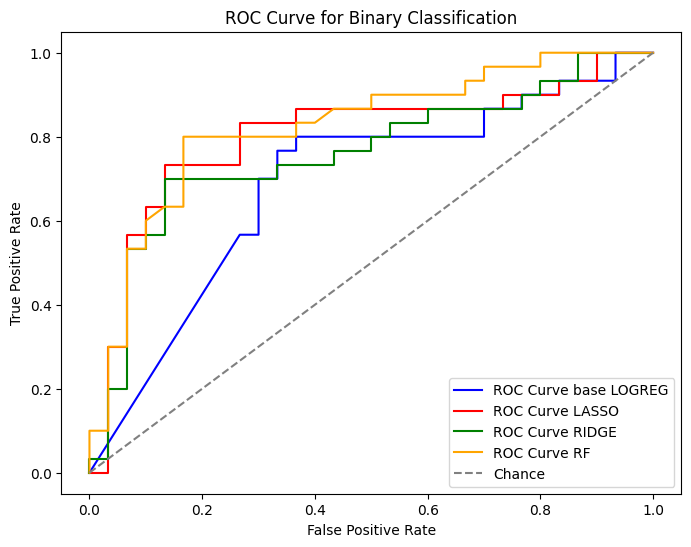

AUC for base LOGREG: 0.6877777777777778
AUC for LASSO: 0.801111111111111
AUC for RIDGE: 0.7611111111111112
AUC for RF: 0.8244444444444445


In [ ]:
#auc roc simple log regression
#AUC-ROC Log.REg
from sklearn.metrics import roc_curve

pred_prob = log_reg.predict_proba(X_test_scaled)[:,1] #to have only the probabilities of class 1 (y=1)

fpr, tpr, _ = roc_curve(y_test, pred_prob) #plotting TPR vs FPR by varying the threshold t:
                                                  # for example i can choose : threshold = 0.5

pred_prob_lasso = optimal_lasso_log_reg.predict_proba(X_test_scaled)[:,1]
pred_prob_ridge = optimal_ridge_log_reg.predict_proba(X_test_scaled)[:,1]

fpr_lasso, tpr_lasso, _ = roc_curve(y_test, pred_prob_lasso)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, pred_prob_ridge)

rf_probs     = rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# Plot the ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve base LOGREG")
plt.plot(fpr_lasso, tpr_lasso, color='red', label=f"ROC Curve LASSO")
plt.plot(fpr_ridge, tpr_ridge, color='green', label=f"ROC Curve RIDGE")
plt.plot(rf_fpr, rf_tpr, color='orange', label=f"ROC Curve RF")

# Plot the diagonal line representing random chance
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Chance")

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Classification")
plt.legend(loc="lower right")
plt.show()

#calculate the AUC scores
from sklearn.metrics import roc_auc_score

auc_logreg = roc_auc_score(y_test, pred_prob)
auc_lasso = roc_auc_score(y_test, pred_prob_lasso)
auc_ridge = roc_auc_score(y_test, pred_prob_ridge)
auc_rf = roc_auc_score(y_test, rf_probs)

list_aucs = list()
list_aucs.append(auc_logreg)
list_aucs.append(auc_lasso)
list_aucs.append(auc_ridge)
list_aucs.append(auc_rf)

print(f"AUC for base LOGREG: {auc_logreg}")
print(f"AUC for LASSO: {auc_lasso}")
print(f"AUC for RIDGE: {auc_ridge}")
print(f"AUC for RF: {auc_rf}")

As Final model i would pick RF since it has the highest AUC score closer to 1 (perfect classification)